In [1]:
#######################################################################################
# Read Me Section:
## Name:
# Kaylen Smith Darnbrook
# Student ID:
# 2135667
# Course:
# M.S.c Machine Learning and Artificial Intelligence
# Module:
## FaceGeneration and Analysis:
## Description: 
# This module is repsonsible for the creation and testing of 
# the Dynamic UNet, a convolutional UNet which makes use of Convolution layers. 
#####################################################################################

In [2]:
# Import Relevant Libraries:
!pip install wandb
!pip install lpips
# Import modules for system managment, io and file management 
import os 
import random

# Import modules for data manipulation and analysis
import numpy as np
import pandas as pd
import scipy as sp

# Import modules for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook")
from PIL import Image

# Import modules for Deep learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
torch.set_float32_matmul_precision('medium')
torch.autograd.set_detect_anomaly(True)

# Pytorch Lightning Modules:
import pytorch_lightning as pL
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.callbacks import LearningRateMonitor

# Import modules for model selection and evaluation.

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Import the DataLoader
#from BinomDataset4 import FacesDataset
from PoissonDataset10 import FacesDataset
from PoissonValidator2 import ValidationSetGenerator

import wandb 
from pytorch_lightning.loggers import WandbLogger
from inference2 import sample_image_3

# Visualisation Software
import numpy as np
import lpips

In [3]:
def Sample_Image(input_image, model,  max_psnr, max_its = 1000, beta = 0.005, save_every_n = 10, device = 'cuda'):
    channels = 3
    batch_size = 1
    pixels_x = 128
    pixels_y = 128

    model = model.to(device)
    model.eval()
    input_image = input_image.to(device)

    denoised, photons, stack, i = sample_image_3(input_image, model, max_its = max_its, max_psnr = max_psnr, 
                                                 beta = beta, save_every_n = save_every_n)
    return denoised, photons, stack, i

In [4]:
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "red"
plt.rc("text", usetex = False)
plt.rc("font", family = "Times New Roman")
plt.rcParams["axes.grid"] = False

In [5]:
## Configuration
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
GREYSCALE = False

# Set the path to the data
root_path = r"ffhq256_dataset/ffhq256"  # Replace with the Directory the FFHQ256 dataset is stored in
out_dir =r"TestSet"  # Replace with the Directory to save the generated images
Batch_Size = 32
load_pretained = False
NUM_Features = 128 * 128
max_epochs = 80
patience = 10
minpsnr = -40
maxpsnr = 32

Device: cuda


In [6]:
from IPython.display import display
def Plot_Creater(Psnr_Distribution, SSIM_Distribution, Perceptual_Distribution, minpsnr, maxpsnr):

    Psnr_Distribution = pd.DataFrame(Psnr_Distribution, columns = ["PSNR"])
    Psnr_Distribution["Pseudo_PSNR"] = np.linspace(minpsnr, maxpsnr, Psnr_Distribution.shape[0])
    Psnr_Distribution["PSNR_Average"] = Psnr_Distribution["PSNR"].rolling(window = 12).mean()
    Psnr_Distribution["PSNR_Variance"] = Psnr_Distribution["PSNR"].rolling(window = 12).std()
    Psnr_Distribution["PSNR_Variance_Upper"] = Psnr_Distribution["PSNR_Average"] + Psnr_Distribution["PSNR"].rolling(window = 12).std()
    Psnr_Distribution["PSNR_Variance_Lower"] = Psnr_Distribution["PSNR_Average"] - Psnr_Distribution["PSNR"].rolling(window = 12).std()   
    Psnr_Distribution.dropna(inplace = True)
    display(Psnr_Distribution.describe())

    SSIM_Distribution = pd.DataFrame(SSIM_Distribution, columns = ["SSIM"])
    SSIM_Distribution["Pseudo_PSNR"] = np.linspace(minpsnr, maxpsnr, SSIM_Distribution.shape[0])
    SSIM_Distribution["SSIM_Average"] = SSIM_Distribution["SSIM"].rolling(window = 12).mean()
    SSIM_Distribution["SSIM_Variance"] = SSIM_Distribution["SSIM"].rolling(window = 12).std()
    SSIM_Distribution["SSIM_Variance_Upper"] = SSIM_Distribution["SSIM_Average"] + SSIM_Distribution["SSIM"].rolling(window = 12).std()
    SSIM_Distribution["SSIM_Variance_Lower"] = SSIM_Distribution["SSIM_Average"] - SSIM_Distribution["SSIM"].rolling(window = 12).std()
    SSIM_Distribution.dropna(inplace = True)
    display(SSIM_Distribution.describe())

    Perceptual_Distribution = pd.DataFrame(Perceptual_Distribution, columns = ["1-PL"])
    Perceptual_Distribution["Pseudo_PSNR"] = np.linspace(minpsnr, maxpsnr, Perceptual_Distribution.shape[0])
    Perceptual_Distribution["1-PL_Average"] = Perceptual_Distribution["1-PL"].rolling(window = 12).mean()
    Perceptual_Distribution["1-PL_Variance"] = Perceptual_Distribution["1-PL"].rolling(window = 12).std()
    Perceptual_Distribution["1-PL_Variance_Upper"] = Perceptual_Distribution["1-PL_Average"] + Perceptual_Distribution["1-PL_Average"].rolling(window = 12).std()
    Perceptual_Distribution["1-PL_Variance_Lower"] = Perceptual_Distribution["1-PL_Average"] - Perceptual_Distribution["1-PL_Average"].rolling(window = 12).std()
    Perceptual_Distribution.dropna(inplace = True)
    display(Perceptual_Distribution.describe())

    plt.Figure(figsize=(10,10))
    sns.set_style("darkgrid")
    sns.scatterplot(data = Psnr_Distribution, x = "Pseudo_PSNR", y = "PSNR", alpha = 0.5)
    sns.lineplot(data = Psnr_Distribution, x = "Pseudo_PSNR", y = "PSNR_Average", color = "red")
    sns.lineplot(data = Psnr_Distribution, x = "Pseudo_PSNR", y = "PSNR_Variance_Upper", color = "blue")
    sns.lineplot(data = Psnr_Distribution, x = "Pseudo_PSNR", y = "PSNR_Variance_Lower", color = "green")
    Psnr_Area = np.trapz(Psnr_Distribution["PSNR_Average"].values, Psnr_Distribution["Pseudo_PSNR"].values)
    #plt.fill_between(Psnr_Distribution_1["Pseudo_PSNR"].values, Psnr_Distribution_1["PSNR"].values, color='skyblue', alpha=0.4)  # Optional: Fill under the curve
    plt.xlabel("Pseudo_Psnr")
    plt.ylabel("PSNR")
    plt.title("Psnr vs Pseudo_Psnr")
    plt.show()

    plt.Figure(figsize=(10,10))
    sns.set_style("darkgrid")
    sns.scatterplot(data = SSIM_Distribution, x = "Pseudo_PSNR", y = "SSIM", alpha = 0.5)
    sns.lineplot(data = SSIM_Distribution, x = "Pseudo_PSNR", y = "SSIM_Average", color = "red")
    sns.lineplot(data = SSIM_Distribution, x = "Pseudo_PSNR", y = "SSIM_Variance_Upper", color = "blue")
    sns.lineplot(data = SSIM_Distribution, x = "Pseudo_PSNR", y = "SSIM_Variance_Lower", color = "green")
    SSIM_Area = np.trapz(SSIM_Distribution["SSIM_Average"].values, SSIM_Distribution["Pseudo_PSNR"].values)
    #plt.fill_between(Psnr_Distribution_1["Pseudo_PSNR"].values, Psnr_Distribution_1["PSNR"].values, color='skyblue', alpha=0.4)  # Optional: Fill under the curve
    plt.xlabel("Pseudo_Psnr")
    plt.ylabel("SSIM")
    plt.title("SSIM vs Pseudo_Psnr")
    plt.show()

    plt.Figure(figsize=(10,10))
    sns.scatterplot(data = Perceptual_Distribution, x = "Pseudo_PSNR", y = "1-PL", alpha = 0.5)
    sns.lineplot(data = Perceptual_Distribution, x = "Pseudo_PSNR", y = "1-PL_Average", color = "red") 
    sns.lineplot(data = Perceptual_Distribution, x = "Pseudo_PSNR", y = "1-PL_Variance_Upper", color = "blue")
    sns.lineplot(data = Perceptual_Distribution, x = "Pseudo_PSNR", y = "1-PL_Variance_Lower", color = "green")
    Perceptual_Area = np.trapz(Perceptual_Distribution["1-PL_Average"].values, Perceptual_Distribution["Pseudo_PSNR"].values)
    #plt.fill_between(Psnr_Distribution_1["Pseudo_PSNR"].values, Psnr_Distribution_1["PSNR"].values, color='skyblue', alpha=0.4)  # Optional: Fill under the curve
    plt.xlabel("Pseudo_Psnr")
    plt.ylabel("1-Perceptual_Loss")
    plt.title("1-Perceptual_Loss vs Pseudo_Psnr")
    plt.show()

    print(f"Psnr Area: {Psnr_Area}, SSIM Area: {SSIM_Area}, Perceptual Area: {Perceptual_Area}")

    print("Mean Psnr",Psnr_Distribution["PSNR"].mean())
    print("Std Psnr",Psnr_Distribution["PSNR"].std()) 
    print("Min Psnr",Psnr_Distribution["PSNR"].min()) 
    print("Max Psnr",Psnr_Distribution["PSNR"].max())
    print("Mean Roll Var",Psnr_Distribution["PSNR_Variance"].mean())

    print("Mean SSIM",SSIM_Distribution["SSIM"].mean())
    print("Std SSIM",SSIM_Distribution["SSIM"].std()) 
    print("Min SSIM",SSIM_Distribution["SSIM"].min()) 
    print("Max SSIM",SSIM_Distribution["SSIM"].max())
    print("Mean Roll SSIM",SSIM_Distribution["SSIM_Variance"].mean())

    print("Mean 1-PL",Perceptual_Distribution["1-PL"].mean())
    print("Std 1-PL",Perceptual_Distribution["1-PL"].std()) 
    print("Min 1-PL",Perceptual_Distribution["1-PL"].min()) 
    print("Max 1-PL",Perceptual_Distribution["1-PL"].max())
    print("Mean Roll 1-PL",Perceptual_Distribution["1-PL_Variance"].mean())

    return Psnr_Area, SSIM_Area, Perceptual_Area

In [7]:
Steps = 9
Spacing = (maxpsnr - minpsnr) // Steps
PSNR_Ranges = [(i, j) for i, j in zip(range(minpsnr, maxpsnr, Spacing), range(minpsnr + Spacing, maxpsnr + Spacing, Spacing))]
print(PSNR_Ranges)

[(-40, -32), (-32, -24), (-24, -16), (-16, -8), (-8, 0), (0, 8), (8, 16), (16, 24), (24, 32)]


In [8]:
def PSNR(original, transformed, maximum):
    mse = np.mean((original-transformed)**2)
    if mse == 0:
        return 100
    max_pixel_value = maximum
    psnr = 20 * np.log10(max_pixel_value/np.sqrt(mse))
    return psnr

def SSIM(original, transformed):
    return sp.signal.ssim(original, transformed, multichannel=True)

def Psuedo_PSNR(original, transformed, image_size, maximum):
    mse = np.mean((original-transformed)**2)
    intensity = transformed/image_size
    if intensity == 0 or mse == 0:
        return 100
    max_pixel = maximum
    signal_score = intensity * image_size * original
    psnr = 20 * np.log(signal_score/np.sqrt(mse))
    return psnr

def Estimated_Psuedo_PSNR(transformed, image_size):
    intensity = transformed/image_size
    return 10 * np.log(intensity)

In [9]:
def plot_random_persons(images, sample = 9):
    random_image_indexes=np.array(random.sample(list(range(len(images))),sample))
    images = np.array([np.asarray(Image.open(os.path.join(root_path, images[index]))) for index in random_image_indexes])

    if (np.sqrt(sample) - int(np.sqrt(sample))) == 0:
        sqrt = int(np.sqrt(sample))
        Length, width = sqrt, sqrt
    else:
        Length, width = 1, sample
    
    fig = plt.figure(figsize=(15,15))
    for index, values in enumerate(random_image_indexes):
        images = np.array(images)
        image = (images[index] - images[index].min())/(images[index].max() - images[index].min())
        plt.subplot(Length,width,index+1)
        plt.imshow(image)
        plt.title(f'Person_id: {random_image_indexes[index]}\nShape: {images[index].shape}')
    return fig

37621.png
70000


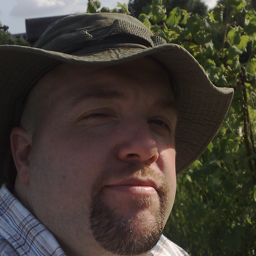

In [10]:
Image_Paths = [img for img in os.listdir(root_path)]
print(Image_Paths[0])
print(len(Image_Paths ))
Image.open(os.path.join(root_path, Image_Paths[50128]))

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

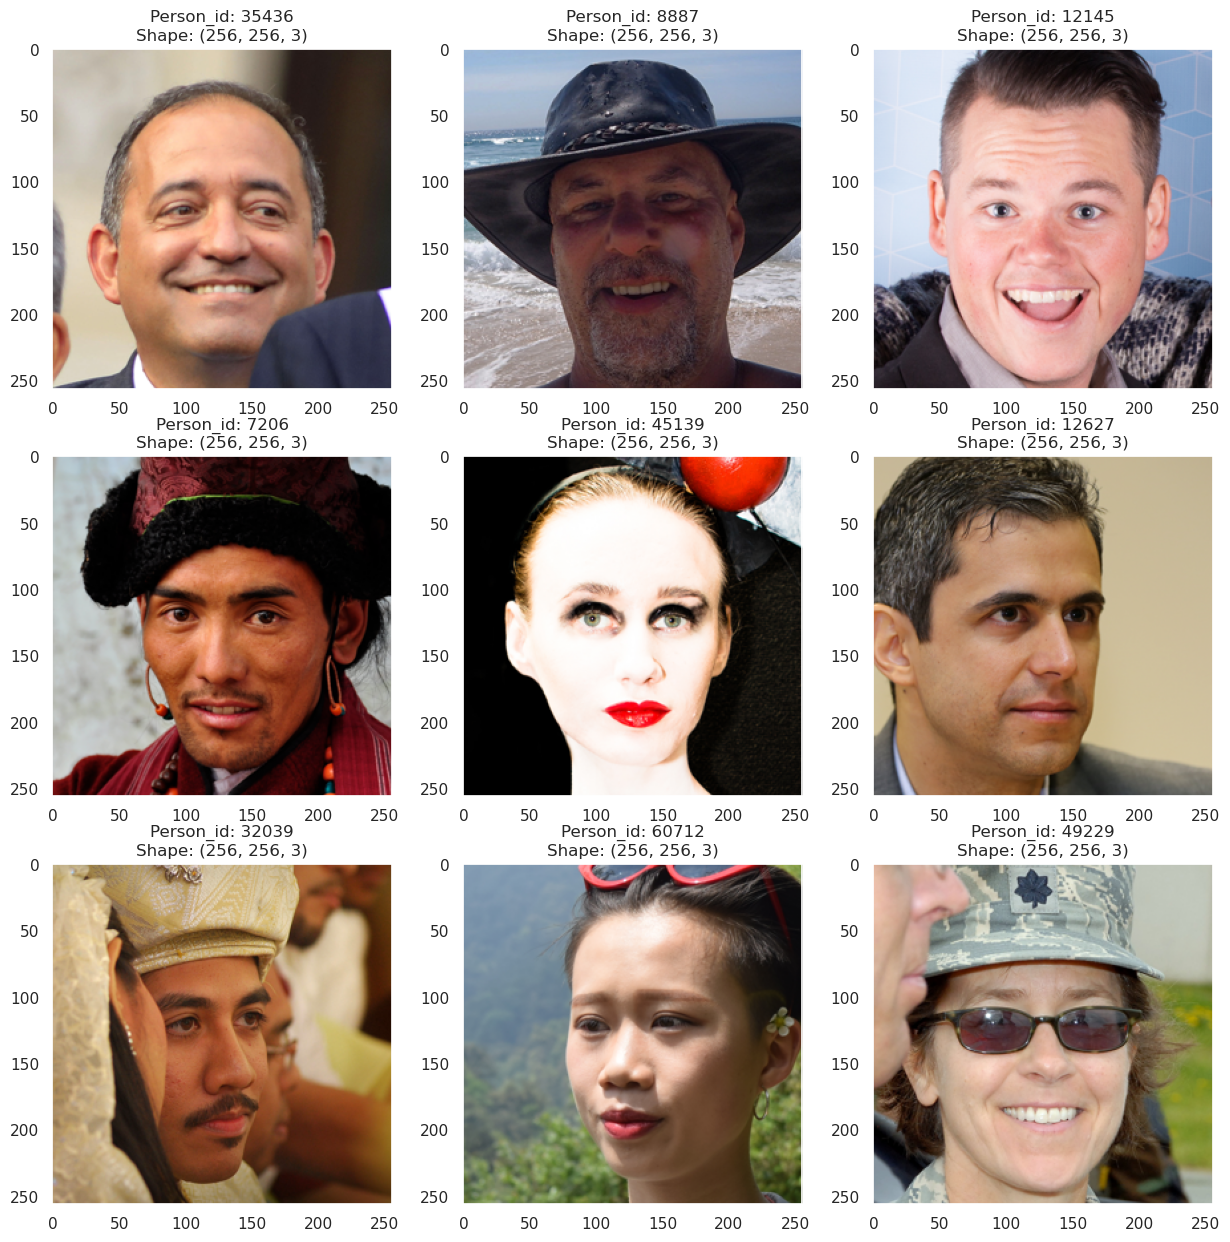

In [11]:
Image_Paths = [img for img in os.listdir(root_path)]
fig = plot_random_persons(Image_Paths, sample = 9)

In [12]:
Directory = [path for path in os.listdir(root_path)]
rng = np.random.default_rng(seed)
indices = rng.permutation(len(Directory))
split_index = int(len(Directory) * 0.8)
train_indices = indices[:split_index]
val_indices = indices[split_index:]
train_indices.shape, val_indices.shape

((56000,), (14000,))

In [13]:
Train_Paths = [Directory[index] for index in train_indices]
Val_Paths = [Directory[index] for index in val_indices]
Paths = Train_Paths.copy()
Paths.extend(Val_Paths)
np.shape(Train_Paths), np.shape(Val_Paths), np.shape(Paths)

((56000,), (14000,), (70000,))

In [14]:
print(PSNR_Ranges[-9][0], PSNR_Ranges[-1][1])
Train_Dataset = FacesDataset(root_dir = root_path, names = Train_Paths, minPSNR= PSNR_Ranges[-9][0] , maxPSNR = PSNR_Ranges[-1][1], augment = True, grayscale= GREYSCALE, virtSize = 512*Batch_Size, amplification_factor = 1e3)
Val_Dataset = FacesDataset(root_dir = root_path, names = Val_Paths, minPSNR= PSNR_Ranges[-9][0], maxPSNR = PSNR_Ranges[-1][1], augment = False, grayscale= GREYSCALE, virtSize = 128*Batch_Size, amplification_factor = 1e3)
Train_Loader = DataLoader(Train_Dataset, batch_size = Batch_Size, shuffle = True)
Validation_Loader = DataLoader(Val_Dataset, batch_size = Batch_Size, shuffle = False)
Train_Dataset.__len__(), Val_Dataset.__len__()

-40 32


(16384, 4096)

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

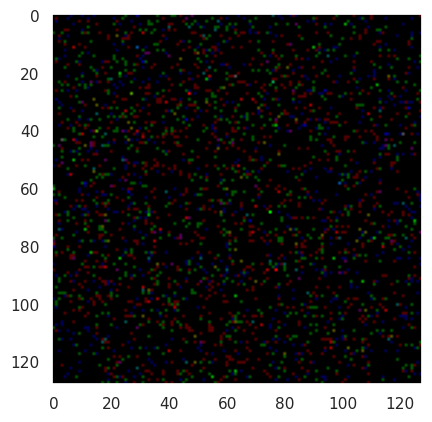

PSNR: -12.433809280395508
True PSNR: -8.05482610996352


In [15]:
ImageNoise, psnr_map, image_target = Train_Dataset.__getitem__(42)
ImageNoise = ImageNoise.detach().cpu().numpy().transpose(1,2,0)
image_target = image_target.detach().cpu().numpy().transpose(1,2,0)
normalised_noisy_image = ImageNoise/ImageNoise.mean()
normalised_image_target = image_target/image_target.mean()
true_psnr = psnr(normalised_image_target, normalised_noisy_image, data_range = normalised_image_target.max() - normalised_image_target.min())
normalised_image_target = (image_target - image_target.min())/(image_target.max() - image_target.min())
normalised_noisy_image = (ImageNoise - ImageNoise.min())/(ImageNoise.max() - ImageNoise.min())
plt.imshow(normalised_noisy_image)
plt.show()
print(f"PSNR: {psnr_map.min().detach().cpu().numpy()}")
print(f"True PSNR: {true_psnr}")

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

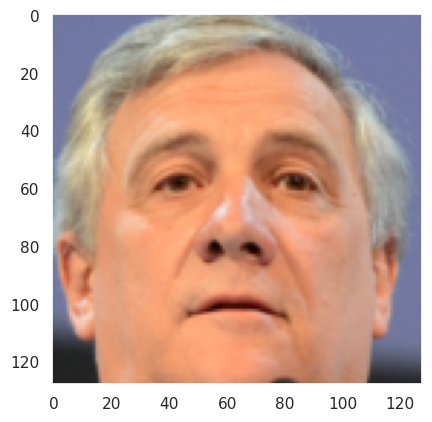

In [16]:
plt.imshow(normalised_image_target)
plt.show()

In [17]:
# Grabs the Validation Paths for the Validation Noisy Images, PSNR Maps and Target Images.
Noisy_Images_Paths = []
Psnr_Maps_Paths = []
Image_Targets_Paths = []
with open(r"Validation_File_PathNames/NoisyImageNames.txt", "r") as File:  # Replace with the Dirctory Pathnames are stored in
    for line in File.readlines():
        Noisy_Images_Paths.append(line[:-1])
with open(r"Validation_File_PathNames/Psnr_MapNames.txt", "r") as File:
    for line in File.readlines():
        Psnr_Maps_Paths.append(line[:-1])
with open(r"Validation_File_PathNames/TargetImageNames.txt", "r") as File:
    for line in File.readlines():
        Image_Targets_Paths.append(line[:-1])
len(Noisy_Images_Paths), len(Psnr_Maps_Paths), len(Image_Targets_Paths)

(10, 10, 10)

In [18]:
Validation_Noisy_Images = {}
Validation_Psnr_Maps = {}
Validation_Target_Images = {}
val_Steps = 10
val_minpsnr = -40
val_maxpsnr = 40
val_Spacing = (val_maxpsnr - val_minpsnr) // val_Steps
val_psnr_ranges = [(i, j) for i, j in zip(range(val_minpsnr, val_maxpsnr, val_Spacing), range(val_minpsnr + val_Spacing, val_maxpsnr + val_Spacing, val_Spacing))]
print(len(val_psnr_ranges))
FaceValidators = [ValidationSetGenerator(root_dir= root_path, out_dir=out_dir, names = Paths, minPSNR= val_psnr_ranges[i][0], targetPSNR = val_psnr_ranges[i][1], augment= True, sample_size = 100, grayscale= GREYSCALE, amplification_factor= 1e2) for i in range(len(val_psnr_ranges))]
FaceValidators[0].out_dir
print(val_psnr_ranges)
for index in range(len(val_psnr_ranges)):
    psnr_label = str(val_psnr_ranges[index][0]) + str(val_psnr_ranges[index][1])
    print(f"Loading Validation Data for {index} Val_Dataset at psnr range {psnr_label}")
    FaceValidator = FaceValidators[index]
    File_Path_NI = Noisy_Images_Paths[index]
    File_Path_PSM = Psnr_Maps_Paths[index]
    File_Path_TI = Image_Targets_Paths[index]
    Noisy_Images, Psnr_Maps, Target_Images = FaceValidator.Load_Noisy_Faces(File_Path_NI, File_Path_PSM, File_Path_TI, device=device)
    Validation_Noisy_Images[psnr_label] = Noisy_Images
    Validation_Psnr_Maps[psnr_label] = Psnr_Maps
    Validation_Target_Images[psnr_label] = Target_Images
len(Validation_Noisy_Images), len(Validation_Psnr_Maps), len(Validation_Target_Images)

10
[(-40, -32), (-32, -24), (-24, -16), (-16, -8), (-8, 0), (0, 8), (8, 16), (16, 24), (24, 32), (32, 40)]
Loading Validation Data for 0 Val_Dataset at psnr range -40-32
Loading Validation Data for 1 Val_Dataset at psnr range -32-24
Loading Validation Data for 2 Val_Dataset at psnr range -24-16
Loading Validation Data for 3 Val_Dataset at psnr range -16-8
Loading Validation Data for 4 Val_Dataset at psnr range -80
Loading Validation Data for 5 Val_Dataset at psnr range 08


/home/linux/KaylenGAP/MScGAPProject/PoissonValidator2.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Noisy_Images = torch.load(file_path_NI)
/home/linux/KaylenGAP/MSc

Loading Validation Data for 6 Val_Dataset at psnr range 816
Loading Validation Data for 7 Val_Dataset at psnr range 1624
Loading Validation Data for 8 Val_Dataset at psnr range 2432
Loading Validation Data for 9 Val_Dataset at psnr range 3240


(10, 10, 10)

In [19]:
Validation_Noisy_Images.keys()

dict_keys(['-40-32', '-32-24', '-24-16', '-16-8', '-80', '08', '816', '1624', '2432', '3240'])

In [20]:
ValidationNoisyTest_Batch = torch.zeros((len(Validation_Noisy_Images), 3, 128, 128))
ValidationPsnrTest_Batch = torch.zeros((len(Validation_Noisy_Images), 3, 128, 128))
ValidationTargetTest_Batch = torch.zeros((len(Validation_Noisy_Images), 3, 128, 128))
for index, key in enumerate(Validation_Noisy_Images.keys()):
    ValidationNoisyTest_Batch[index] = Validation_Noisy_Images[key][-10]
    ValidationPsnrTest_Batch[index] = Validation_Psnr_Maps[key][-10].view(1, 3, 128, 128)
    ValidationTargetTest_Batch[index] = Validation_Target_Images[key][-10]
ValidationNoisyTest_Batch.shape, ValidationPsnrTest_Batch.shape, ValidationTargetTest_Batch.shape

(torch.Size([10, 3, 128, 128]),
 torch.Size([10, 3, 128, 128]),
 torch.Size([10, 3, 128, 128]))

In [21]:
ValidationNoisyTest_Batch = ValidationNoisyTest_Batch.to(device)
ValidationPsnrTest_Batch = ValidationPsnrTest_Batch.to(device)
ValidationTargetTest_Batch = ValidationTargetTest_Batch.to(device)

In [23]:
from AdvancedGatedUNet_Final import GatedUNet
name = "FaceGenerationFinalAdvGatedResUNet-m40-32"
CHECKPOINT_PATH = "./models/"
levels = 10
channels = 3
depth = 5
up_mode = "upsample"
merge_mode = "concat"
num_layers = 1
dropout_rate = 0.2
learning_rate = 1e-3
weight_decay = 1e-5
starting_filters = 50
num_blocks_per_layer = 1
epochs = max_epochs
mini_batches = 512
warm_up_epochs = 10
activation = nn.LeakyReLU()
alpha = 0.2

model = GatedUNet(levels = levels, channels = channels, 
                  depth = depth, up_mode = up_mode, 
                  merge_mode = merge_mode, num_layers = num_layers, 
                  dropout_rate = dropout_rate, activation= activation,
                  starting_filters = starting_filters, 
                  num_blocks_per_layer = num_blocks_per_layer, 
                  epochs = epochs, mini_batches = mini_batches,
                  alpha = alpha).to(device)
model

/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation'])`.
/home/linux/KaylenGAP/MScGAPProject/AdvancedGatedUNet_Final.py:512: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  init.kaiming_normal(m.weight, nonlinearity = "leaky_relu")
/home/linux/KaylenGAP/MScGAPProject/AdvancedGatedUNet_Final.py:514: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.bias, 0)
/home/linux/KaylenGAP/MScGAPProject/AdvancedGatedUNet_Final.py:517: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.weight, 1)
/home/linux/KaylenGAP/MScGAPProject/AdvancedGatedUNet_Final.py:518: FutureWarning: `nn.init.constant` is now depre

GatedUNet(
  (activation): LeakyReLU(negative_slope=0.01)
  (encoder): ModuleList(
    (0): DownConvolutionBlock(
      (activation): LeakyReLU(negative_slope=0.01)
      (Skip_Block): Sequential(
        (0): Conv2d(30, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(10, 50, eps=1e-05, affine=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (Main_Processing_Block): Sequential(
        (0): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(10, 50, eps=1e-05, affine=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(10, 50, eps=1e-05, affine=True)
        (5): LeakyReLU(negative_slope=0.01)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout2d(p=0.2, inplace=False)
      (gated_convolution_gate): Gated_Convolution(
        (conv): Conv2

In [23]:
# Set the configuration 
hyperparameters = {
        "learning_rate": learning_rate,
        "epochs": max_epochs,
        "batch_size": Batch_Size,
        "root_path": root_path,
        "out_dir": out_dir,
        "load_pretained": load_pretained,
        "max_epochs": max_epochs,
        "patience": patience,
        "minpsnr": minpsnr,
        "maxpsnr": maxpsnr,
        "device":"cuda",
        "seed": seed,
        "GREYSCALE":GREYSCALE,
        "NUM_Features": NUM_Features,
        "num_conditions": 5,
        "n_channels": 64, 
        "activation": "LeakyReLU",
        "dropout_rate": 0.3,
        "amplification_factor": 1e3,
        "virtSize": 512*Batch_Size
    }

In [24]:
# Initialize wandb logger
wandb_logger = WandbLogger(
    project="GAP_Model_CrossAttnUNet",
    log_model=True,  # Log checkpoints and best model
    config = hyperparameters
)

In [25]:
# Assuming wandb_logger and other necessary variables are already defined
Trainer = pL.Trainer(
    default_root_dir=os.path.join(CHECKPOINT_PATH, name),
    gradient_clip_val=1.0,
    accelerator="gpu", 
    devices=[0],
    #precision=16,  # Use 16-bit precision (mixed precision) for faster training
    max_epochs=max_epochs,
    logger=wandb_logger,
    enable_checkpointing=False,  # Disable automatic checkpointing
    callbacks=[
        # Uncomment the ModelCheckpoint if you want to save the model
        # ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
        LearningRateMonitor(logging_interval="epoch"),  # Log learning rate every epoch
        EarlyStopping(monitor='val_loss', patience=15)  # Stop training early if no improvement
    ]
)
Trainer.fit(model, Train_Loader, Validation_Loader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: oia295 (oia295-university-of-birmingham). Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:461: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.

  | Name                    | Type                 | Params | Mode 
-------------------------------------------------------------------------
0 | activation              | LeakyReLU            | 0      | train
1 | encoder                 | ModuleList           | 34.6 M | train
2 | noise_estimator         | NoiseEstimator       | 22.2 K | train
3 | Bottleneck_Intermediate | ModuleList           | 1.3 M  | train
4 | Up_Intermediates_Convs  | ModuleList           | 861 K  | train
5 | Hierarchical_ResBlock   | HierarchicalResBlock | 409    | train
6 | Bottleneck_Block        | ModuleList           | 103 M  | train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [27]:
Trainer.test(model, Train_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   -0.07285837084054947    │
│       test_mse_loss       │    0.06042198836803436    │
│     test_photon_loss      │   -0.13328039646148682    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.07285837084054947,
  'test_photon_loss': -0.13328039646148682,
  'test_mse_loss': 0.06042198836803436}]

In [28]:
Trainer.test(model, Train_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -0.0757499560713768    │
│       test_mse_loss       │    0.06001579016447067    │
│     test_photon_loss      │   -0.13576580584049225    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.0757499560713768,
  'test_photon_loss': -0.13576580584049225,
  'test_mse_loss': 0.06001579016447067}]

In [29]:
Trainer.test(model, Validation_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   -0.07660948485136032    │
│       test_mse_loss       │    0.06005651503801346    │
│     test_photon_loss      │   -0.13666598498821259    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.07660948485136032,
  'test_photon_loss': -0.13666598498821259,
  'test_mse_loss': 0.06005651503801346}]

In [37]:
Trainer.test(model, Validation_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   -0.07278614491224289    │
│       test_mse_loss       │    0.0607500895857811     │
│     test_photon_loss      │    -0.133536234498024     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.07278614491224289,
  'test_photon_loss': -0.133536234498024,
  'test_mse_loss': 0.0607500895857811}]

In [23]:
model = GatedUNet.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/linux/anaconda3/envs/GAPProj

In [26]:
lpips_model = lpips.LPIPS(net='alex').to(device)

def Generate_Psnr_Scores(model, Noisy_Images, Psnr_Maps, Target_Images):
    model.eval()
    model = model.to(device)
    Noisy_Images = Noisy_Images.to(device)
    Psnr_Maps = Psnr_Maps.to(device)
    Target_Images = Target_Images.to(device)

    Predictions = torch.zeros(Noisy_Images.shape[0], 3, 128, 128).to(device)
    
    # Process batches correctly without slicing errors
    batch_size = 32
    with torch.no_grad():
        for i in range(0, Noisy_Images.shape[0], batch_size):
            batch_end = min(i + batch_size, Noisy_Images.shape[0])  # Ensure no overflow
            Predictions[i:batch_end] = model(Noisy_Images[i:batch_end])[0].detach()

        # Adjust predictions after getting model output
        Predictions = torch.exp(Predictions - Predictions.max())  # Handle exp safely to avoid overflow
        Predictions = Noisy_Images.detach().sum(dim=(1, 2, 3), keepdim=True) * Predictions / Predictions.sum(dim=(1, 2, 3), keepdim=True)
        
        perceptual_score = lpips_model(Target_Images, Predictions)
        perceptual_score = 1 - perceptual_score
        
        # Move everything to CPU for further processing
        Noisy_Images = Noisy_Images.cpu().numpy()
        Target_Images = Target_Images.cpu().numpy()
        Predictions = Predictions.cpu().numpy()
        perceptual_score = perceptual_score.cpu().numpy()

        # Normalize Predictions correctly
        Predictions = Predictions / Predictions.mean(axis=(1, 2, 3), keepdims=True)
        
        # Compute PSNR and SSIM scores
        Psnr_Scores = [psnr(Target_Image, Prediction, data_range=Target_Image.max() - Target_Image.min()) for Target_Image, Prediction in zip(Target_Images, Predictions)]
        SSIM_Scores = [ssim(Target_Image, Prediction, data_range=Target_Image.max() - Target_Image.min(), channel_axis=0) for Target_Image, Prediction in zip(Target_Images, Predictions)]
        
        return Psnr_Scores, SSIM_Scores, perceptual_score.reshape(-1,)

Psnr_Distribution = []
SSIM_Distribution = []
Perceptual_Distribution = []

for key in Validation_Noisy_Images.keys():
    if key == "3240":
        continue
    print(key)
    Psnr_Scores, SSIM_Scores, Perceptual_Scores = Generate_Psnr_Scores(model, Validation_Noisy_Images[key], Validation_Psnr_Maps[key], Validation_Target_Images[key])
    Psnr_Distribution.extend(Psnr_Scores)
    SSIM_Distribution.extend(SSIM_Scores)
    Perceptual_Distribution.extend(Perceptual_Scores)

Psnr_Distribution = np.array(Psnr_Distribution)
SSIM_Distribution = np.array(SSIM_Distribution)
Perceptual_Distribution = np.array(Perceptual_Distribution)
Psnr_Distribution.shape, SSIM_Distribution.shape, Perceptual_Distribution.shape

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
-40-32


/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_pa

-32-24
-24-16
-16-8
-80
08
816
1624
2432


((900,), (900,), (900,))

,PSNR,Pseudo_PSNR,PSNR_Average,PSNR_Variance,PSNR_Variance_Upper,PSNR_Variance_Lower
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,23.777089,-3.559511,23.656986,1.521994,25.178979,22.134992
std,7.350759,20.564969,7.198228,0.394834,7.265234,7.152422
min,9.746040,-39.119021,13.055332,0.723680,14.327317,11.301418
25%,16.983048,-21.339266,16.851124,1.246230,18.170416,15.358992
50%,23.633188,-3.559511,23.378467,1.458324,24.781080,21.965866
75%,30.406887,14.220245,30.743268,1.746708,32.639896,29.014856
max,37.844858,32.000000,34.451635,2.949600,36.890824,33.312706


,SSIM,Pseudo_PSNR,SSIM_Average,SSIM_Variance,SSIM_Variance_Upper,SSIM_Variance_Lower
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.686778,-3.559511,0.682991,0.050149,0.733140,0.632842
std,0.227938,20.564969,0.222152,0.024228,0.205002,0.240523
min,0.195275,-39.119021,0.328060,0.006568,0.395079,0.258933
25%,0.479791,-21.339266,0.455556,0.027059,0.514717,0.394483
50%,0.709855,-3.559511,0.702480,0.054906,0.761931,0.645751
75%,0.915861,14.220245,0.905877,0.070444,0.938841,0.864711
max,0.981354,32.000000,0.970724,0.098365,1.028859,0.963366


,1-PL,Pseudo_PSNR,1-PL_Average,1-PL_Variance,1-PL_Variance_Upper,1-PL_Variance_Lower
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,0.467503,-3.119021,0.463921,0.054488,0.473271,0.454571
std,0.305067,20.310653,0.300343,0.021978,0.303221,0.297585
min,-0.054053,-38.238042,0.095316,0.010976,0.097889,0.090943
25%,0.130397,-20.678532,0.122218,0.036146,0.125672,0.118180
50%,0.619711,-3.119021,0.671387,0.056778,0.691270,0.649316
75%,0.754189,14.440489,0.736117,0.072762,0.745378,0.724833
max,0.927319,32.000000,0.859033,0.107613,0.870733,0.850187


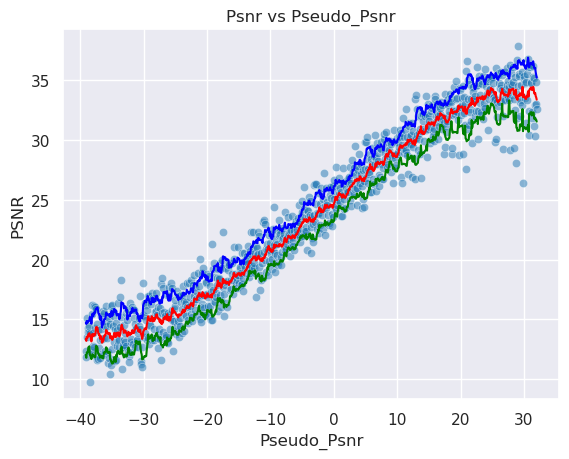

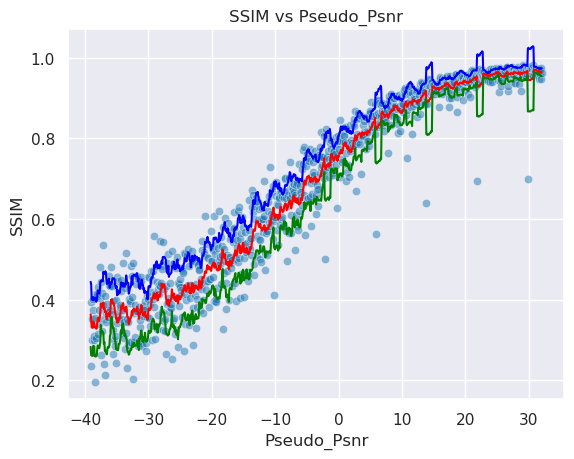

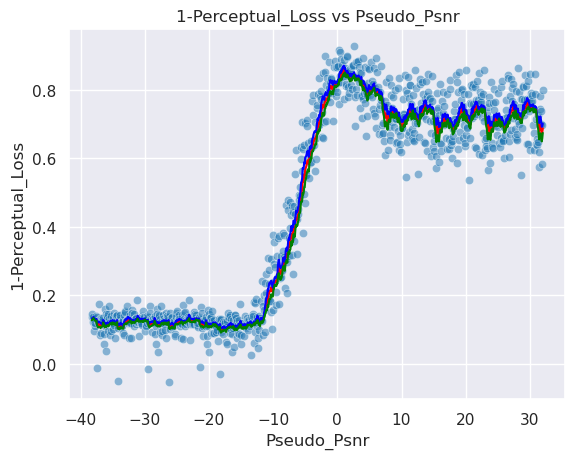

Psnr Area: 1682.4847919643637, SSIM Area: 48.575156922219065, Perceptual Area: 32.58932556511961
Mean Psnr 23.777089227958246
Std Psnr 7.350759006900126
Min Psnr 9.746040286173226
Max Psnr 37.84485780571654
Mean Roll Var 1.5219935310865473
Mean SSIM 0.68677753
Std SSIM 0.2279382199048996
Min SSIM 0.1952747255563736
Max SSIM 0.9813539981842041
Mean Roll SSIM 0.05014887391574218
Mean 1-PL 0.46750292
Std 1-PL 0.30506688356399536
Min 1-PL -0.05405306816101074
Max 1-PL 0.9273187518119812
Mean Roll 1-PL 0.05448775802430261


(1682.4847919643637, 48.575156922219065, 32.58932556511961)

In [27]:
Plot_Creater(Psnr_Distribution, SSIM_Distribution, Perceptual_Distribution, minpsnr, maxpsnr)

In [29]:
np.save("Data/Psnr_Distribution_11.npy", Psnr_Distribution)
np.save("Data/SSIM_Distribution_11.npy", SSIM_Distribution)
np.save("Data/Perceptual_Distribution_11.npy", Perceptual_Distribution)

In [32]:
print(PSNR_Ranges[-1][0], PSNR_Ranges[-1][1])
Train_Dataset = FacesDataset(root_dir = root_path, names = Train_Paths, minPSNR= PSNR_Ranges[-1][0] , maxPSNR = PSNR_Ranges[-1][1], augment = True, grayscale= GREYSCALE, virtSize = 512*Batch_Size, amplification_factor = 1e3)
Val_Dataset = FacesDataset(root_dir = root_path, names = Val_Paths, minPSNR= PSNR_Ranges[-1][0], maxPSNR = PSNR_Ranges[-1][1], augment = False, grayscale= GREYSCALE, virtSize = 128*Batch_Size, amplification_factor = 1e3)
Train_Loader = DataLoader(Train_Dataset, batch_size = Batch_Size, shuffle = True)
Validation_Loader = DataLoader(Val_Dataset, batch_size = Batch_Size, shuffle = False)
Train_Dataset.__len__(), Val_Dataset.__len__()

24 32


(16384, 4096)

In [33]:
from HierarchicalUNet_Final import HierarchicalUNet
name = "FaceGenerationFinalHierarchicalUNet-m40-32"
CHECKPOINT_PATH = "./models/"
levels = 10
channels = 3
depth = 5
up_mode = "upsample"
merge_mode = "concat"
num_layers = 1
dropout_rate = 0.2
learning_rate = 1e-3
weight_decay = 1e-5
starting_filters = 42
num_blocks_per_layer = 1
epochs = max_epochs
mini_batches = 512
warm_up_epochs = 10
activation = nn.LeakyReLU()
epochs = max_epochs
alpha = 0.2
temperature = 0.1
start_temperature = 20.0
final_temperature = 1.0
warm_temperature_epochs = 10
reduction_factor = 16
num_kernels = 4
train_dataset = Train_Dataset
validation_dataset = Val_Dataset
minpsnr = PSNR_Ranges[-9][0]    
maxpsnr = PSNR_Ranges[-1][1]
alpha_start = 0.0001
alpha_end = 0.001
epochs_per_phase = 8
minpsnr_initial = PSNR_Ranges[-1][0]
auxiliary = 0.2

model = HierarchicalUNet(levels = levels, channels = channels,
                            depth = depth, up_mode = up_mode, 
                            merge_mode = merge_mode, num_layers = num_layers, 
                            dropout_rate = dropout_rate, activation= activation,
                            starting_filters = starting_filters, 
                            num_blocks_per_layer = num_blocks_per_layer, 
                            epochs = epochs, mini_batches = mini_batches,
                            alpha = alpha, temperature = temperature, 
                            start_temperature = start_temperature, 
                            final_temperature = final_temperature, 
                            warm_temperature_epochs = warm_temperature_epochs, 
                            reduction_factor = reduction_factor,
                            num_kernels = num_kernels, 
                            minpsnr_initial = minpsnr_initial,
                            train_dataset = train_dataset, 
                            validation_dataset = validation_dataset,
                            minpsnr = minpsnr, maxpsnr = maxpsnr, 
                            alpha_start = alpha_start, alpha_end = alpha_end, 
                            epochs_per_phase = epochs_per_phase, 
                            auxiliary = auxiliary).to(device)

In [34]:
model

HierarchicalUNet(
  (activation): LeakyReLU(negative_slope=0.01)
  (encoder): ModuleList(
    (0): DownConvolutionBlock(
      (activation): LeakyReLU(negative_slope=0.01)
      (Skip_Block): Sequential(
        (0): Conv2d(30, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(7, 42, eps=1e-05, affine=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (Main_Processing_Block): Dynamic_Sequential(
        (layers): ModuleList(
          (0): DynamicConv2d(
            (Attention): Attention_Block(
              (Conditioning_Network): Sequential(
                (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): GroupNorm(1, 2, eps=1e-05, affine=True)
                (2): LeakyReLU(negative_slope=0.01)
              )
              (Dense): Linear(in_features=42, out_features=2, bias=True)
              (Dense_2): Linear(in_features=2, out_features=4, bias=True)
              (GlobalPool): AdaptiveAvgPool2d(o

In [35]:
# Set the configuration 
hyperparameters = {
        "learning_rate": learning_rate,
        "epochs": max_epochs,
        "batch_size": Batch_Size,
        "root_path": root_path,
        "out_dir": out_dir,
        "load_pretained": load_pretained,
        "max_epochs": max_epochs,
        "patience": patience,
        "minpsnr": minpsnr,
        "maxpsnr": maxpsnr,
        "device":"cuda",
        "seed": seed,
        "GREYSCALE":GREYSCALE,
        "NUM_Features": NUM_Features,
        "num_conditions": 5,
        "n_channels": 64, 
        "activation": "LeakyReLU",
        "dropout_rate": 0.3,
        "amplification_factor": 1e3,
        "virtSize": 512*Batch_Size
    }

In [36]:
# Initialize wandb logger
wandb_logger = WandbLogger(
    project="GAP_Model_CrossAttnUNet",
    log_model=True,  # Log checkpoints and best model
    config = hyperparameters
)

In [37]:
# Assuming wandb_logger and other necessary variables are already defined
Trainer = pL.Trainer(
    default_root_dir=os.path.join(CHECKPOINT_PATH, name),
    gradient_clip_val=1.0,
    accelerator="gpu", 
    devices=[0],
    #precision=16,  # Use 16-bit precision (mixed precision) for faster training
    max_epochs=max_epochs,
    logger=wandb_logger,
    enable_checkpointing=False,  # Disable automatic checkpointing
    callbacks=[
        # Uncomment the ModelCheckpoint if you want to save the model
        # ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
        LearningRateMonitor(logging_interval="epoch"),  # Log learning rate every epoch
        #EarlyStopping(monitor='val_loss', patience=15)  # Stop training early if no improvement
    ]
)
Trainer.fit(model, Train_Loader, Validation_Loader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                 | Params | Mode 
-------------------------------------------------------------------------
0 | activation              | LeakyReLU            | 0      | train
1 | encoder                 | ModuleList           | 19.2 M | train
2 | noise_estimator         | NoiseEstimator       | 33.1 K | train
3 | Hierarchical_ResBlock   | HierarchicalResBlock | 279    | train
4 | Up_Intermediates_Convs  | ModuleList           | 4.3 M  | train
5 | Bottleneck_Intermediate | ModuleList           | 8.1 M  | train
6 | Bottleneck_Block        | ModuleList           | 57.3 M | train
7 | decoder                 | ModuleList           | 29.8 M | train
8 | output                  | Conv2d               | 129    | train
-------------------------------------------------------------------------
118 M     Tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: 16.0 - 32
Current Phase: 1/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: 8.0 - 32
Current Phase: 2/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: 0.0 - 32
Current Phase: 3/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: -8.0 - 32
Current Phase: 4/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: -16.0 - 32
Current Phase: 5/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: -24.0 - 32
Current Phase: 6/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: -32.0 - 32
Current Phase: 7/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=64` reached.


Current PSNR Range: -40 - 32
Current Phase: 8/8
Psnr_Step -8.0
Target PSNR:  -40


In [38]:
Trainer.test(model, Train_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   -0.07168921083211899    │
│       test_mse_loss       │    0.06215997412800789    │
│     test_photon_loss      │   -0.13384917378425598    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.07168921083211899,
  'test_photon_loss': -0.13384917378425598,
  'test_mse_loss': 0.06215997412800789}]

In [40]:
Trainer.test(model, Validation_Loader)   

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   -0.06938021630048752    │
│       test_mse_loss       │    0.06229456514120102    │
│     test_photon_loss      │   -0.13167478144168854    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.06938021630048752,
  'test_photon_loss': -0.13167478144168854,
  'test_mse_loss': 0.06229456514120102}]

In [43]:
lpips_model = lpips.LPIPS(net='alex').to(device)

def Generate_Psnr_Scores(model, Noisy_Images, Psnr_Maps, Target_Images):
    model.eval()
    model = model.to(device)
    Noisy_Images = Noisy_Images.to(device)
    Psnr_Maps = Psnr_Maps.to(device)
    Target_Images = Target_Images.to(device)

    Predictions = torch.zeros(Noisy_Images.shape[0], 3, 128, 128).to(device)
    
    # Process batches correctly without slicing errors
    batch_size = 32
    with torch.no_grad():
        for i in range(0, Noisy_Images.shape[0], batch_size):
            batch_end = min(i + batch_size, Noisy_Images.shape[0])  # Ensure no overflow
            Predictions[i:batch_end] = model(Noisy_Images[i:batch_end])[0].detach()

        # Adjust predictions after getting model output
        Predictions = torch.exp(Predictions - Predictions.max())  # Handle exp safely to avoid overflow
        Predictions = Noisy_Images.detach().sum(dim=(1, 2, 3), keepdim=True) * Predictions / Predictions.sum(dim=(1, 2, 3), keepdim=True)
        
        perceptual_score = lpips_model(Target_Images, Predictions)
        perceptual_score = 1 - perceptual_score
        
        # Move everything to CPU for further processing
        Noisy_Images = Noisy_Images.cpu().numpy()
        Target_Images = Target_Images.cpu().numpy()
        Predictions = Predictions.cpu().numpy()
        perceptual_score = perceptual_score.cpu().numpy()

        # Normalize Predictions correctly
        Predictions = Predictions / Predictions.mean(axis=(1, 2, 3), keepdims=True)
        
        # Compute PSNR and SSIM scores
        Psnr_Scores = [psnr(Target_Image, Prediction, data_range=Target_Image.max() - Target_Image.min()) for Target_Image, Prediction in zip(Target_Images, Predictions)]
        SSIM_Scores = [ssim(Target_Image, Prediction, data_range=Target_Image.max() - Target_Image.min(), channel_axis=0) for Target_Image, Prediction in zip(Target_Images, Predictions)]
        
        return Psnr_Scores, SSIM_Scores, perceptual_score.reshape(-1,)

Psnr_Distribution = []
SSIM_Distribution = []
Perceptual_Distribution = []

for key in Validation_Noisy_Images.keys():
    if key == "3240":
        continue
    print(key)
    Psnr_Scores, SSIM_Scores, Perceptual_Scores = Generate_Psnr_Scores(model, Validation_Noisy_Images[key], Validation_Psnr_Maps[key], Validation_Target_Images[key])
    Psnr_Distribution.extend(Psnr_Scores)
    SSIM_Distribution.extend(SSIM_Scores)
    Perceptual_Distribution.extend(Perceptual_Scores)

Psnr_Distribution = np.array(Psnr_Distribution)
SSIM_Distribution = np.array(SSIM_Distribution)
Perceptual_Distribution = np.array(Perceptual_Distribution)
Psnr_Distribution.shape, SSIM_Distribution.shape, Perceptual_Distribution.shape

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
-40-32
-32-24
-24-16
-16-8
-80
08
816
1624
2432


((900,), (900,), (900,))

,PSNR,Pseudo_PSNR,PSNR_Average,PSNR_Variance,PSNR_Variance_Upper,PSNR_Variance_Lower
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,24.315809,-3.559511,24.172096,1.386715,25.558811,22.785381
std,8.062786,20.564969,7.930206,0.310706,7.877680,7.994472
min,9.614431,-39.119021,12.869231,0.662602,14.205883,11.318309
25%,16.782969,-21.339266,16.561417,1.156797,17.937158,14.994784
50%,23.810487,-3.559511,23.568118,1.352296,25.041859,22.086234
75%,31.662080,14.220245,31.472396,1.588864,33.018960,29.953944
max,40.018369,32.000000,37.410292,2.569433,39.262766,36.146155


,SSIM,Pseudo_PSNR,SSIM_Average,SSIM_Variance,SSIM_Variance_Upper,SSIM_Variance_Lower
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.692519,-3.559511,0.688571,0.046325,0.734896,0.642246
std,0.236854,20.564969,0.231927,0.024936,0.210284,0.254174
min,0.188810,-39.119021,0.323284,0.002900,0.390640,0.246122
25%,0.467483,-21.339266,0.439831,0.022697,0.507307,0.368972
50%,0.726111,-3.559511,0.713353,0.051847,0.772970,0.660466
75%,0.929216,14.220245,0.927845,0.066902,0.948961,0.905621
max,0.990330,32.000000,0.984649,0.104472,1.011915,0.980624


,1-PL,Pseudo_PSNR,1-PL_Average,1-PL_Variance,1-PL_Variance_Upper,1-PL_Variance_Lower
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,0.479172,-3.119021,0.475413,0.052415,0.484544,0.466282
std,0.313914,20.310653,0.309724,0.020797,0.312388,0.307181
min,-0.052791,-38.238042,0.094598,0.010729,0.097042,0.091621
25%,0.130498,-20.678532,0.122353,0.035118,0.125645,0.118429
50%,0.636432,-3.119021,0.693547,0.054767,0.711818,0.670820
75%,0.771065,14.440489,0.756434,0.068856,0.766704,0.745314
max,0.929280,32.000000,0.874323,0.100182,0.883480,0.869224


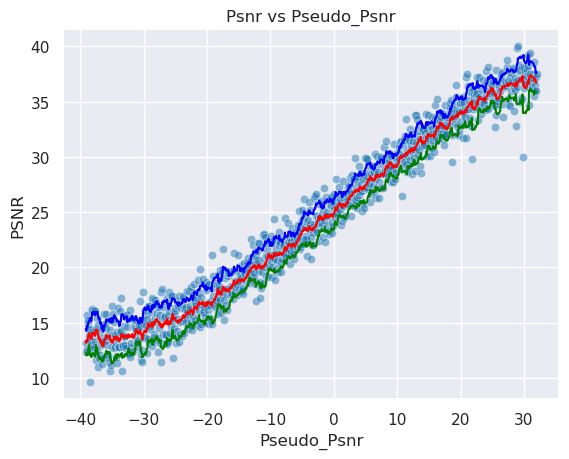

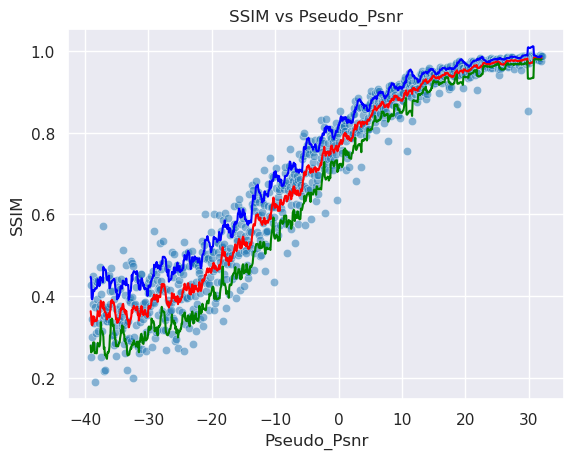

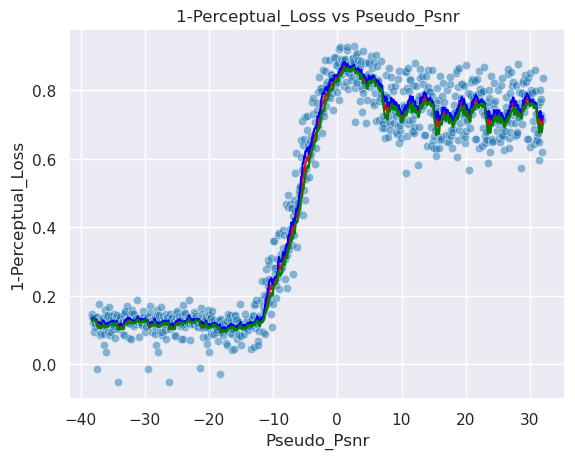

Psnr Area: 1719.024638810707, SSIM Area: 48.97174997627735, Perceptual Area: 33.396330867381195
Mean Psnr 24.31580908991597
Std Psnr 8.062786205941777
Min Psnr 9.614431225179661
Max Psnr 40.01836888433941
Mean Roll Var 1.386715148131953
Mean SSIM 0.6925187
Std SSIM 0.23685382306575775
Min SSIM 0.18881039321422577
Max SSIM 0.9903300404548645
Mean Roll SSIM 0.04632509877864944
Mean 1-PL 0.4791717
Std 1-PL 0.3139142692089081
Min 1-PL -0.05279123783111572
Max 1-PL 0.929280161857605
Mean Roll 1-PL 0.0524145655727734


(1719.024638810707, 48.97174997627735, 33.396330867381195)

In [44]:
Plot_Creater(Psnr_Distribution, SSIM_Distribution, Perceptual_Distribution, minpsnr, maxpsnr)

In [45]:
np.save("Data/Psnr_Distribution_14.npy", Psnr_Distribution)
np.save("Data/SSIM_Distribution_14.npy", SSIM_Distribution)
np.save("Data/Perceptual_Distribution_14.npy", Perceptual_Distribution)

In [28]:
print(PSNR_Ranges[-1][0], PSNR_Ranges[-1][1])
Train_Dataset = FacesDataset(root_dir = root_path, names = Train_Paths, minPSNR= PSNR_Ranges[-1][0] , maxPSNR = PSNR_Ranges[-1][1], augment = True, grayscale= GREYSCALE, virtSize = 512*Batch_Size, amplification_factor = 1e3)
Val_Dataset = FacesDataset(root_dir = root_path, names = Val_Paths, minPSNR= PSNR_Ranges[-1][0], maxPSNR = PSNR_Ranges[-1][1], augment = False, grayscale= GREYSCALE, virtSize = 128*Batch_Size, amplification_factor = 1e3)
Train_Loader = DataLoader(Train_Dataset, batch_size = Batch_Size, shuffle = True)
Validation_Loader = DataLoader(Val_Dataset, batch_size = Batch_Size, shuffle = False)
Train_Dataset.__len__(), Val_Dataset.__len__()

24 32


(16384, 4096)

In [29]:
from HierarchicalUNet_Final import HierarchicalUNet
name = "FaceGenerationFinalHierarchicalUNet-m40-32"
CHECKPOINT_PATH = "./models/"
levels = 10
channels = 3
depth = 5
up_mode = "upsample"
merge_mode = "concat"
num_layers = 1
dropout_rate = 0.2
learning_rate = 1e-3
weight_decay = 1e-5
starting_filters = 50
num_blocks_per_layer = 1
epochs = max_epochs
mini_batches = 512
warm_up_epochs = 10
activation = nn.LeakyReLU()
alpha = 0.2
temperature = 0.1
start_temperature = 20.0
final_temperature = 1.0
warm_temperature_epochs = 10
reduction_factor = 16
num_kernels = 4
train_dataset = Train_Dataset
validation_dataset = Val_Dataset
minpsnr = PSNR_Ranges[-9][0]    
maxpsnr = PSNR_Ranges[-1][1]
alpha_start = 0.0001
alpha_end = 0.001
epochs_per_phase = 10
minpsnr_initial = PSNR_Ranges[-1][0]
auxiliary = 0.2

model = HierarchicalUNet(levels = levels, channels = channels,
                            depth = depth, up_mode = up_mode, 
                            merge_mode = merge_mode, num_layers = num_layers, 
                            dropout_rate = dropout_rate, activation= activation,
                            starting_filters = starting_filters, 
                            num_blocks_per_layer = num_blocks_per_layer, 
                            epochs = epochs, mini_batches = mini_batches,
                            alpha = alpha, temperature = temperature, 
                            start_temperature = start_temperature, 
                            final_temperature = final_temperature, 
                            warm_temperature_epochs = warm_temperature_epochs, 
                            reduction_factor = reduction_factor,
                            num_kernels = num_kernels, 
                            minpsnr_initial = minpsnr_initial,
                            train_dataset = train_dataset, 
                            validation_dataset = validation_dataset,
                            minpsnr = minpsnr, maxpsnr = maxpsnr, 
                            alpha_start = alpha_start, alpha_end = alpha_end, 
                            epochs_per_phase = epochs_per_phase, 
                            auxiliary = auxiliary).to(device)

/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation'])`.


In [30]:
# Set the configuration 
hyperparameters = {
        "learning_rate": learning_rate,
        "epochs": max_epochs,
        "batch_size": Batch_Size,
        "root_path": root_path,
        "out_dir": out_dir,
        "load_pretained": load_pretained,
        "max_epochs": max_epochs,
        "patience": patience,
        "minpsnr": minpsnr,
        "maxpsnr": maxpsnr,
        "device":"cuda",
        "seed": seed,
        "GREYSCALE":GREYSCALE,
        "NUM_Features": NUM_Features,
        "num_conditions": 5,
        "n_channels": 64, 
        "activation": "LeakyReLU",
        "dropout_rate": 0.3,
        "amplification_factor": 1e3,
        "virtSize": 512*Batch_Size
    }

In [31]:
# Initialize wandb logger
wandb_logger = WandbLogger(
    project="GAP_Model_CrossAttnUNet",
    log_model=True,  # Log checkpoints and best model
    config = hyperparameters
)

In [32]:
# Assuming wandb_logger and other necessary variables are already defined
Trainer = pL.Trainer(
    default_root_dir=os.path.join(CHECKPOINT_PATH, name),
    gradient_clip_val=1.0,
    accelerator="gpu", 
    devices=[0],
    #precision=16,  # Use 16-bit precision (mixed precision) for faster training
    max_epochs=max_epochs,
    logger=wandb_logger,
    enable_checkpointing=False,  # Disable automatic checkpointing
    callbacks=[
        # Uncomment the ModelCheckpoint if you want to save the model
        # ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
        LearningRateMonitor(logging_interval="epoch"),  # Log learning rate every epoch
        #EarlyStopping(monitor='val_loss', patience=15)  # Stop training early if no improvement
    ]
)
Trainer.fit(model, Train_Loader, Validation_Loader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                   | Params | Mode 
---------------------------------------------------------------------------
0 | activation              | LeakyReLU              | 0      | train
1 | encoder                 | ModuleList             | 27.2 M | train
2 | noise_estimator         | NoiseEstimator         | 33.1 K | train
3 | Hierarchical_ResBlock   | HierarchicalResBlock   | 4.4 K  | train
4 | contrastive_loss        | LogProbContrastiveLoss | 0      | train
5 | Up_Intermediates_Convs  | ModuleList         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: 16.0 - 32
Current Phase: 1/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: 8.0 - 32
Current Phase: 2/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: 0.0 - 32
Current Phase: 3/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: -8.0 - 32
Current Phase: 4/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: -16.0 - 32
Current Phase: 5/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: -24.0 - 32
Current Phase: 6/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Current PSNR Range: -32.0 - 32
Current Phase: 7/8
Psnr_Step -8.0
Target PSNR:  -40


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.


Current PSNR Range: -40 - 32
Current Phase: 8/8
Psnr_Step -8.0
Target PSNR:  -40


In [34]:
Trainer.test(model, Train_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   -0.07434515655040741    │
│       test_mse_loss       │   0.060702841728925705    │
│     test_photon_loss      │   -0.13504794239997864    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.07434515655040741,
  'test_photon_loss': -0.13504794239997864,
  'test_mse_loss': 0.060702841728925705}]

In [35]:
Trainer.test(model, Validation_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   -0.07412436604499817    │
│       test_mse_loss       │    0.0627669170498848     │
│     test_photon_loss      │    -0.1368912309408188    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.07412436604499817,
  'test_photon_loss': -0.1368912309408188,
  'test_mse_loss': 0.0627669170498848}]

In [36]:
lpips_model = lpips.LPIPS(net='alex').to(device)

def Generate_Psnr_Scores(model, Noisy_Images, Psnr_Maps, Target_Images):
    model.eval()
    model = model.to(device)
    Noisy_Images = Noisy_Images.to(device)
    Psnr_Maps = Psnr_Maps.to(device)
    Target_Images = Target_Images.to(device)

    Predictions = torch.zeros(Noisy_Images.shape[0], 3, 128, 128).to(device)
    
    # Process batches correctly without slicing errors
    batch_size = 32
    with torch.no_grad():
        for i in range(0, Noisy_Images.shape[0], batch_size):
            batch_end = min(i + batch_size, Noisy_Images.shape[0])  # Ensure no overflow
            Predictions[i:batch_end] = model(Noisy_Images[i:batch_end])[0].detach()

        # Adjust predictions after getting model output
        Predictions = torch.exp(Predictions - Predictions.max())  # Handle exp safely to avoid overflow
        Predictions = Noisy_Images.detach().sum(dim=(1, 2, 3), keepdim=True) * Predictions / Predictions.sum(dim=(1, 2, 3), keepdim=True)
        
        perceptual_score = lpips_model(Target_Images, Predictions)
        perceptual_score = 1 - perceptual_score
        
        # Move everything to CPU for further processing
        Noisy_Images = Noisy_Images.cpu().numpy()
        Target_Images = Target_Images.cpu().numpy()
        Predictions = Predictions.cpu().numpy()
        perceptual_score = perceptual_score.cpu().numpy()

        # Normalize Predictions correctly
        Predictions = Predictions / Predictions.mean(axis=(1, 2, 3), keepdims=True)
        
        # Compute PSNR and SSIM scores
        Psnr_Scores = [psnr(Target_Image, Prediction, data_range=Target_Image.max() - Target_Image.min()) for Target_Image, Prediction in zip(Target_Images, Predictions)]
        SSIM_Scores = [ssim(Target_Image, Prediction, data_range=Target_Image.max() - Target_Image.min(), channel_axis=0) for Target_Image, Prediction in zip(Target_Images, Predictions)]
        
        return Psnr_Scores, SSIM_Scores, perceptual_score.reshape(-1,)

Psnr_Distribution = []
SSIM_Distribution = []
Perceptual_Distribution = []

for key in Validation_Noisy_Images.keys():
    if key == "3240":
        continue
    print(key)
    Psnr_Scores, SSIM_Scores, Perceptual_Scores = Generate_Psnr_Scores(model, Validation_Noisy_Images[key], Validation_Psnr_Maps[key], Validation_Target_Images[key])
    Psnr_Distribution.extend(Psnr_Scores)
    SSIM_Distribution.extend(SSIM_Scores)
    Perceptual_Distribution.extend(Perceptual_Scores)

Psnr_Distribution = np.array(Psnr_Distribution)
SSIM_Distribution = np.array(SSIM_Distribution)
Perceptual_Distribution = np.array(Perceptual_Distribution)
Psnr_Distribution.shape, SSIM_Distribution.shape, Perceptual_Distribution.shape

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
-40-32


/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_pa

-32-24
-24-16
-16-8
-80
08
816
1624
2432


((900,), (900,), (900,))

,PSNR,Pseudo_PSNR,PSNR_Average,PSNR_Variance,PSNR_Variance_Upper,PSNR_Variance_Lower
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,24.742857,-3.559511,24.583814,1.397427,25.981241,23.186388
std,8.471026,20.564969,8.324166,0.327564,8.301718,8.359398
min,9.606469,-39.119021,12.949023,0.704342,14.218021,11.277864
25%,17.040480,-21.339266,16.786565,1.172209,18.135973,15.387755
50%,23.909247,-3.559511,23.701573,1.349143,25.138503,22.240555
75%,32.304848,14.220245,32.176122,1.562020,33.758639,30.652079
max,42.010038,32.000000,39.406544,2.784078,41.626762,37.887448


,SSIM,Pseudo_PSNR,SSIM_Average,SSIM_Variance,SSIM_Variance_Upper,SSIM_Variance_Lower
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.695544,-3.559511,0.691603,0.047696,0.739300,0.643907
std,0.237073,20.564969,0.231777,0.026169,0.209617,0.254698
min,0.186162,-39.119021,0.324425,0.002267,0.392480,0.245821
25%,0.476082,-21.339266,0.451471,0.021956,0.518476,0.384226
50%,0.736165,-3.559511,0.720453,0.052472,0.778628,0.667428
75%,0.931613,14.220245,0.926587,0.069308,0.951029,0.897325
max,0.992106,32.000000,0.986572,0.104232,1.020217,0.983468


,1-PL,Pseudo_PSNR,1-PL_Average,1-PL_Variance,1-PL_Variance_Upper,1-PL_Variance_Lower
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,0.480553,-3.119021,0.476827,0.052006,0.485931,0.467722
std,0.314148,20.310653,0.310082,0.020611,0.312712,0.307576
min,-0.052542,-38.238042,0.095659,0.011021,0.098094,0.091820
25%,0.130808,-20.678532,0.122701,0.034990,0.126383,0.118785
50%,0.639691,-3.119021,0.691649,0.054418,0.709023,0.670861
75%,0.771609,14.440489,0.756045,0.068621,0.764514,0.745778
max,0.936926,32.000000,0.879533,0.104928,0.888464,0.875888


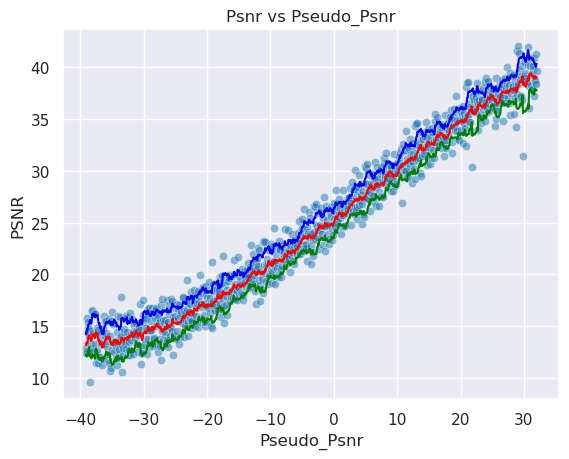

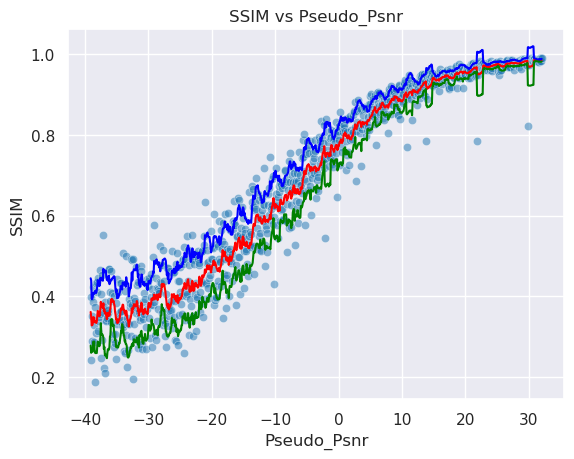

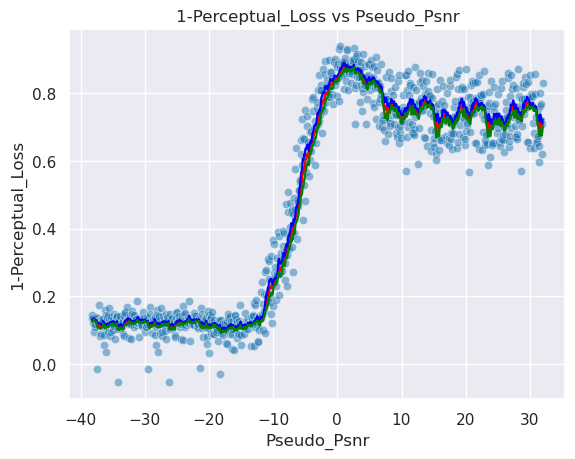

Psnr Area: 1748.2486688726071, SSIM Area: 49.187638821190134, Perceptual Area: 33.495927930673844
Mean Psnr 24.74285714136349
Std Psnr 8.471025983354425
Min Psnr 9.60646894964135
Max Psnr 42.01003848647771
Mean Roll Var 1.3974269695281405
Mean SSIM 0.6955436
Std SSIM 0.23707275092601776
Min SSIM 0.18616223335266113
Max SSIM 0.9921059608459473
Mean Roll SSIM 0.04769625256884159
Mean 1-PL 0.48055315
Std 1-PL 0.3141482174396515
Min 1-PL -0.05254161357879639
Max 1-PL 0.9369257688522339
Mean Roll 1-PL 0.052005939205186535


(1748.2486688726071, 49.187638821190134, 33.495927930673844)

In [37]:
Plot_Creater(Psnr_Distribution, SSIM_Distribution, Perceptual_Distribution, minpsnr, maxpsnr)

In [38]:
np.save("Data/Psnr_Distribution_15.npy", Psnr_Distribution)
np.save("Data/SSIM_Distribution_15.npy", SSIM_Distribution)
np.save("Data/Perceptual_Distribution_15.npy", Perceptual_Distribution)